## Generalized Principal Component Analysis of US Mortality Data

This notebook uses generalized Principal Component Analysis
to aid in understanding the patterns of variation in US
mortality data.

These are the modules that we will be using here:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from gpca import GPCA

This is the path to the data file on your system.  You will need
to change this to match the path used in the `vital_stats_prep.py`
script.

In [2]:
pa = "/nfs/kshedden/cdc_mortality/final/pop_mort.csv"
df = pd.read_csv(pa)

PCA operates on a rectangular data matrix.  Depending on what
we want to focus on, we can choose one of several ways to
create this matrix.  Here, we will pivot the age groups to
the columns to create a rectangular matrix.

In [3]:
ix = ["Year", "Month", "Sex", "Age_group"]
dx = df.set_index(ix)
deaths = dx.loc[:, "Deaths"].unstack("Age_group")
deaths = deaths.fillna(1)

In [4]:
# We may wish to adjust for certain factors, so that the PCA
# focuses on the variation around these factors.  A basic
# factor to adjust for is the population size, so that we are
# looking at mortality with respect to population size ("death rates").
pop = dx.loc[:, "Population"].unstack("Age_group")
lpop = np.log(pop)

Below we fit the generalized PCA, using a Poisson family and
two factors.

In [5]:
pca = GPCA(deaths, 2, offset=lpop, family=sm.families.Poisson())
r = pca.fit(maxiter=2000)

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: divide by zero encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: invalid value encountered in subtract
  return var_weights / scale * (endog * np.log(mu) - mu -


/afs/umich.edu/user/k/s/kshedden/Projects/Workshops/mortality/python/gpca.py:282: UserWarning: GPCA did not converge
  warnings.warn("GPCA did not converge")


The warning about convergence may be ignored as the norm of
the gradient is rather small.

In [6]:
r.score_norm

1.1938833104547

A generalized PCA identifies "intercepts", analogous to means,
such that variables with lesser intercepts tend to have smaller
values than variables with greater intercepts. The plot below shows
the intercepts.

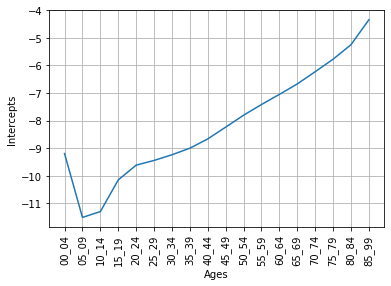

In [7]:
ages = deaths.columns
plt.clf()
plt.grid(True)
plt.plot(ages, r.intercept)
plt.xlabel("Ages")
plt.ylabel("Intercepts")
xl = plt.gca().xaxis.get_ticklabels()
for x in xl:
    x.set_rotation(90)

The intercepts are usually of lesser interest than the factors,
which are analogous to traditional "principal components".  Below
we plot the loadings of the two-factor fit.  Note that the loadings
for each factor consist of a sequence of values corresponding to the
variables (the age categories).

The dominant factor has entirely negative loadings.  As in standard
PCA, )

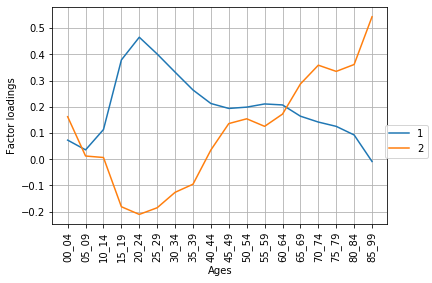

In [8]:
plt.grid(True)
plt.plot(ages, r.factors[:, 0], label="1")
plt.plot(ages, r.factors[:, 1], label="2")
ha, lb = plt.gca().get_legend_handles_labels()
plt.figlegend(ha, lb, "center right")
plt.xlabel("Ages")
plt.ylabel("Factor loadings")
xl = plt.gca().xaxis.get_ticklabels()
for x in xl:
    x.set_rotation(90)

One of the best ways to understand the factors is to look at the scores,
which correspond to the rows of the data matrix.  The scores in our case
are records of deaths in sex x month x year cells.

To make this plot, first prepare a dataframe containing the scores
together with some other relevant variables.

In [9]:
scores = pca.scores(r.params)

dm = dx.index.to_frame().unstack("Age_group")
sex = dm.loc[:, ("Sex", "70_74")].values
month = dm.loc[:, ("Month", "70_74")].values
year = dm.loc[:, ("Year", "70_74")].values

scores = pd.DataFrame(scores, columns=["factor1", "factor2"])
scores["sex"] = sex
scores["month"] = month
scores["year"] = year

The following plot showing the two scores plotted against
each other makes it clear that factor 1 is largely dependent
on sex.  Factor 2 is also dependent on sex, but to a lesser
degree than factor 1.

Text(0, 0.5, 'Scores for component 2')

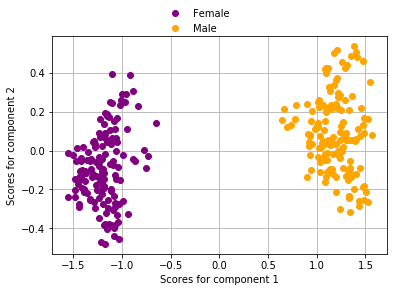

In [10]:
plt.grid(True)
col = {"Female": "purple", "Male": "orange"}
for s in "Female", "Male":
    ii = np.flatnonzero(scores.sex == s)
    plt.plot(scores.factor1[ii], scores.factor2[ii], 'o', color=col[s], label=s)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center")
leg.draw_frame(False)
plt.xlabel("Scores for component 1")
plt.ylabel("Scores for component 2")

In [11]:
def plot_month(factor):
    plt.clf()
    plt.grid(True)
    for sex in "Female", "Male":
        scores1 = scores.loc[scores.sex == sex, :]
        plt.plot(scores1.month, scores1.loc[:, factor], 'o', label=sex)
    plt.ylabel("Month")
    plt.ylabel("Score")
    plt.title(factor)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

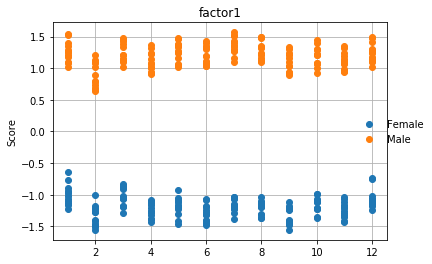

In [12]:
plot_month("factor1")

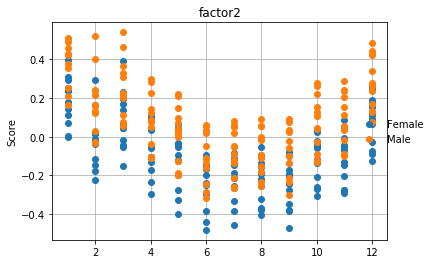

In [13]:
plot_month("factor2")

In [14]:
def plot_year(factor):
    plt.clf()
    plt.grid(True)
    for sex in "Female", "Male":
        scores1 = scores.loc[scores.sex == sex, :]
        plt.plot(scores1.year, scores1.loc[:, factor], 'o', label=sex)
    plt.ylabel("Month")
    plt.ylabel("Score")
    plt.title(factor)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

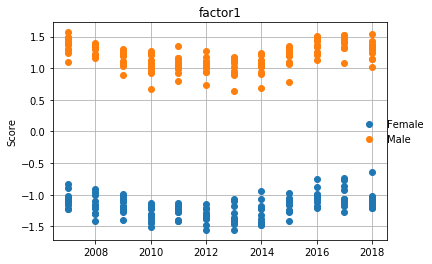

In [15]:
plot_year("factor1")

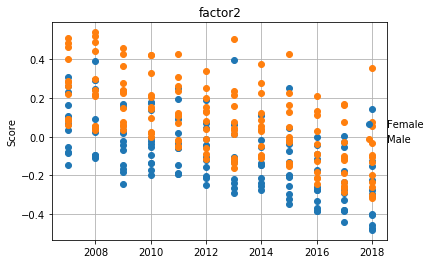

In [16]:
plot_year("factor2")